# Exploración con support vector machine

In [1]:
# Importamos librerias necesarias para realizar el analisis. 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# SVM
from sklearn.model_selection import (
    train_test_split,   
    StratifiedKFold,    
    GridSearchCV     
)
from sklearn.svm import SVC     
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)

# Configuramos las opciones de pandas y seaborn para mejorar la visualización de datos.
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid", palette="muted", color_codes=True)

# Cargamos el dataset de diabetes y mostramos su tamaño.
df = pd.read_csv('../data/processed/diabetes_sample.csv')


In [2]:
Y = df['Diabetes_012']
X = df.drop(columns=["Diabetes_012"])

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=2, stratify=Y
)

In [3]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)

model = SVC(class_weight='balanced', random_state=2)

params = model.get_params()
print("\nParámetros del modelo SVM:")
for param, valor in sorted(params.items()):
    print(f"{param:25s} = {valor}")


Parámetros del modelo SVM:
C                         = 1.0
break_ties                = False
cache_size                = 200
class_weight              = balanced
coef0                     = 0.0
decision_function_shape   = ovr
degree                    = 3
gamma                     = scale
kernel                    = rbf
max_iter                  = -1
probability               = False
random_state              = 2
shrinking                 = True
tol                       = 0.001
verbose                   = False


In [4]:
param_grid = {
    'kernel': ['linear', 'rbf'],   
    'C': [0.01, 0.1, 1, 10],            
    'gamma': ['scale', 'auto']  
}

grid_search = GridSearchCV(
    estimator=model,               
    param_grid=param_grid,
    scoring='f1_macro',            
    cv=cv,                      
    n_jobs=-1,                    
    verbose=2,
    return_train_score=True,    

)

# Entrenamiento con búsqueda de hiperparámetros
grid_search.fit(X_train, Y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


,estimator,SVC(class_wei...andom_state=2)
,param_grid,"{'C': [0.01, 0.1, ...], 'gamma': ['scale', 'auto'], 'kernel': ['linear', 'rbf']}"
,scoring,'f1_macro'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,C,10


In [5]:
print("\nMejores parámetros encontrados:", grid_search.best_params_)
print("Mejor F1 macro en CV:", grid_search.best_score_)

best_model = grid_search.best_estimator_
print("\nMejor modelo entrenado:\n", best_model)


Mejores parámetros encontrados: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Mejor F1 macro en CV: 0.4143018457675886

Mejor modelo entrenado:
 SVC(C=10, class_weight='balanced', gamma='auto', random_state=2)


In [6]:
results = pd.DataFrame(grid_search.cv_results_)

# Seleccionar columnas relevantes para SVM
columns_target = [
    'param_kernel',
    'param_C',
    'param_gamma',
    'mean_train_score',
    'std_train_score',
    'mean_test_score',
    'std_test_score',
    'rank_test_score'
]

# Subset ordenado por el ranking del score
results_subset = results[columns_target].copy()
results_subset = results_subset.sort_values(by='rank_test_score')

print("\nResultados resumidos de la búsqueda ordenados por score:")
print(results_subset.to_string(index=False))


Resultados resumidos de la búsqueda ordenados por score:
param_kernel  param_C param_gamma  mean_train_score  std_train_score  mean_test_score  std_test_score  rank_test_score
         rbf    10.00        auto          0.713561         0.006024         0.414302        0.004325                1
         rbf     1.00        auto          0.544446         0.006228         0.413230        0.005054                2
      linear     0.01       scale          0.416673         0.001606         0.412468        0.005615                3
      linear     0.01        auto          0.416673         0.001606         0.412468        0.005615                3
      linear     0.10        auto          0.416120         0.002083         0.412066        0.005253                5
      linear     0.10       scale          0.416120         0.002083         0.412066        0.005253                5
      linear    10.00        auto          0.415666         0.002036         0.412059        0.005339        

Accuracy: 0.7192221784259625
Precision (macro): 0.40603381381491527
Recall (macro): 0.43644893405065494
F1-score (macro): 0.40962441914279574

Reporte de clasificación:
               precision    recall  f1-score   support

         0.0       0.90      0.77      0.83      6412
         1.0       0.02      0.04      0.02       139
         2.0       0.30      0.50      0.38      1060

    accuracy                           0.72      7611
   macro avg       0.41      0.44      0.41      7611
weighted avg       0.80      0.72      0.75      7611



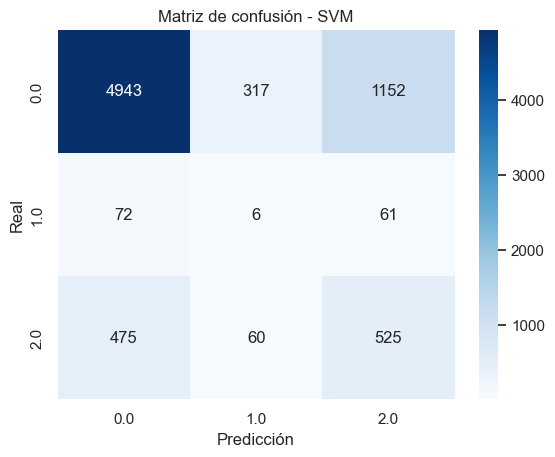

In [7]:
y_pred = best_model.predict(X_test)

# Métricas de evaluación
print("Accuracy:", accuracy_score(Y_test, y_pred))
print("Precision (macro):", precision_score(Y_test, y_pred, average='macro'))
print("Recall (macro):", recall_score(Y_test, y_pred, average='macro'))
print("F1-score (macro):", f1_score(Y_test, y_pred, average='macro'))
print("\nReporte de clasificación:\n", classification_report(Y_test, y_pred))

# Matriz de confusión
cm = confusion_matrix(Y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=np.unique(Y_test), yticklabels=np.unique(Y_test))
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de confusión - SVM")
plt.show()